# Información del trabajo

Este trabajo corresponde a la evaluación práctica del curso de clasificadores probabilísticos dado en la ECI 2019.

El presente trabajo se realizó de manera individual por el alumno Ezequiel Leonardo Castaño

Email de contacto: castanoezequielleonardo@gmail.com

## Metodología

Se han utilizado las funciones hechas en MatLab para realizar realizar los cálculos necesarios y se realizaron complementos en Python para incorporar nuevos gráficos que mejoren la calidad del análisis

# Bibliotecas y carga de datos

Para realizar este trabajo se utilizaron varios bibliotecas específicas de Python:

- **Numpy**: Para el procesamiento eficiente de vectores y matrices
- **Pandas**: Para tener acceso a los datos en forma de DataFrame
- **Matplotlib**: Para la creación de gráficos personalizados
- **Seaborn**: Para tener acceso a una mayor galería de gráficos
- **Scipy.io**: Para poder leer los datos desde los archivos .mat
- **Scipy.stats**: Para obtener de manera rápida y sencilla estadísticos descriptivos
- **Sklearn.metrics**: Para calcular facilmente la curva ROC, el AUC y el Brier Score
- **Oct2Py**: Para ejecutar el código de MatLab con un engine de Octave

En esta primer celda se importan todas las bibliotecas necesarias y se realizan las configuraciones básicas de estética para los gráficos

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
from scipy import stats
from sklearn.metrics import roc_curve, auc, brier_score_loss
from oct2py import Oct2Py

%matplotlib inline
plt.style.use("seaborn")
global_style = {
    "figsize": (12, 8)
    }

color_primary = (0.20392156862745098, 0.5411764705882353, 0.7411764705882353)
color_primary_alt = (0.6509803921568628, 0.023529411764705882, 0.1568627450980392)
color_secondary = (0.47843137254901963, 0.40784313725490196, 0.6509803921568628)
color_secondary_alt = (0.27450980392156865, 0.47058823529411764, 0.12941176470588237)

#### Carga de Datos

Se cargan los datos y se dividen en 4 variables que serán utilizadas a lo largo del trabajo.

In [2]:
mat = scipy.io.loadmat('2019_ECI_datosMatlabCurso/2019_datos_calibracion_sistemas.mat')

Hd_train = mat['sistema4_Hd_train'].flatten()
Hd_test = mat['sistema4_Hd_test'].flatten()

Hp_train = mat['sistema4_Hp_train'].flatten()
Hp_test = mat['sistema4_Hp_test'].flatten()

# Calibración de sistema artificial con buenos datos de entrenamiento

#### Pregunta: ¿Cree que los datos de entrenamiento utilizados en la prueba van a modelar bien la función de calibración a utilizar con los datos de prueba? Razone su respuesta.

Para poder evaluar si los datos son los adecuados, es necesario verificar si las distribuciones que tienen son similares tanto en el conjunto de prueba como en el de entrenamiento.

Para realizar esto se realiza lo siguiente:

- Exploración de los datos y transformaciones
- Identificación de valores atípicos (outliers)
- Comparación de histogramas
- Curva de Calibración

### Exploración de los datos y transformaciones

Es importante entender los datos, cuales son sus valores y algunos estadísticos descriptivos, como su media, mínimo, máximo y dispersión.

In [3]:
def show_stats(describe_output):
    nobs, (mini, maxi), mean, variance, *_ = describe_output
    print(f"Número de observaciones: {nobs} \nMínimo: {mini}\nMáximo: {maxi}\nMedia: {mean} \nVarianza: {variance}\n")

In [4]:
print("H_p Entrenamiento")
show_stats(stats.describe(Hp_train))
print("H_p Prueba")
show_stats(stats.describe(Hp_test))

print("H_d Entrenamiento")
show_stats(stats.describe(Hd_train))
print("H_d Prueba")
show_stats(stats.describe(Hd_test))

H_p Entrenamiento
Número de observaciones: 1000 
Mínimo: 1.745161881860155e-05
Máximo: 2362785341.3131022
Media: 3348588.7639939175 
Varianza: 6107052231449393.0

H_p Prueba
Número de observaciones: 1000 
Mínimo: 6.007893126865488e-07
Máximo: 94687952.75284088
Media: 234256.4012272325 
Varianza: 15517518977504.799

H_d Entrenamiento
Número de observaciones: 1000 
Mínimo: 3.2001765374545792e-12
Máximo: 2102683.5095018996
Media: 2780.613245416545 
Varianza: 4588676239.4061

H_d Prueba
Número de observaciones: 1000 
Mínimo: 2.7183493291350347e-11
Máximo: 267415.1333382354
Media: 869.2860307995261 
Varianza: 210165417.60332194



En primera instancia se puede observar que la **varianza es muy elevada** y que tanto el mínimo como el máximo difieren en varios órdenes de magnitud, por lo anterior, se propone utilizar una transformación logaritmica para manipular los datos más facilmente. En este caso se utilizará el logaritmo en base 10.

In [5]:
print("H_p Entrenamiento")
Hp_train_log = np.log10(Hp_train)
show_stats(stats.describe(Hp_train_log))
print("H_p Prueba")
Hp_test_log = np.log10(Hp_test)
show_stats(stats.describe(Hp_test_log))

print("H_d Entrenamiento")
Hd_train_log = np.log10(Hd_train)
show_stats(stats.describe(Hd_train_log))
print("H_d Prueba")
Hd_test_log = np.log10(Hd_test)
show_stats(stats.describe(Hd_test_log))

H_p Entrenamiento
Número de observaciones: 1000 
Mínimo: -4.758164281519842
Máximo: 9.373424267837267
Media: 1.3973802778724722 
Varianza: 4.630308139100317

H_p Prueba
Número de observaciones: 1000 
Mínimo: -6.221277801507451
Máximo: 7.976294726777413
Media: 1.277421395847429 
Varianza: 4.469598023924653

H_d Entrenamiento
Número de observaciones: 1000 
Mínimo: -11.494826063202716
Máximo: 6.322773908720227
Media: -2.6943521672599218 
Varianza: 6.898946790929841

H_d Prueba
Número de observaciones: 1000 
Mínimo: -10.565694733781882
Máximo: 5.427185980859089
Media: -2.8381089110537525 
Varianza: 6.749136150765961



Con esta transformación, la varianza se ha reducido significativamente y el rango completo de los datos está dentro del intervalo [-12, 7] para los datos de $H_d$y [-7, 10] para los de $H_p$. Es importante destacar que esta transformación puede introducir un error de aproximación ya que si los números originales tenían una precisión elevada que no pudo mantenerse al realizar la transformación, dicha presición se pierde en cierto grado debido a los errores naturales del trabajo con números de coma flotante.

**A partir de este momento se utilizará la conversión logarítmica de los datos**

### Identificación de valores atípicos

Una vez transformados los datos es importante detectar valores atípicos, sin conocer el modelo que los generó, es imposible eliminarlos de manera segura, pero su presencia puede alterar la valides y fiabilidad del modelo a desarrollar. En este caso se utilizará un Box Plot para detectar varoles atípicos en cada dataset.

Al visualizar los box plot es posible ver como los datos son similares en ambos casos, tanto en $H_p$ (train y test) como en $H_d$ (train y test). Se puede ver una diferencia entre Hp y Hd pero, entre más grande sea esa diferencia, mejor será el modelo, ya que entre más separadas estén, más facil será discriminar entre una y otra, disminuyendo el error al escoger un umbral de decisión.

En referencia a los valores atípicos, existen varios valores que podrían considerarse atípicos, de momento se ignorarán. Si la eficiencia del modelo es baja, es importante recordar que tal vez estos puntos tengan una fuerte influencia.

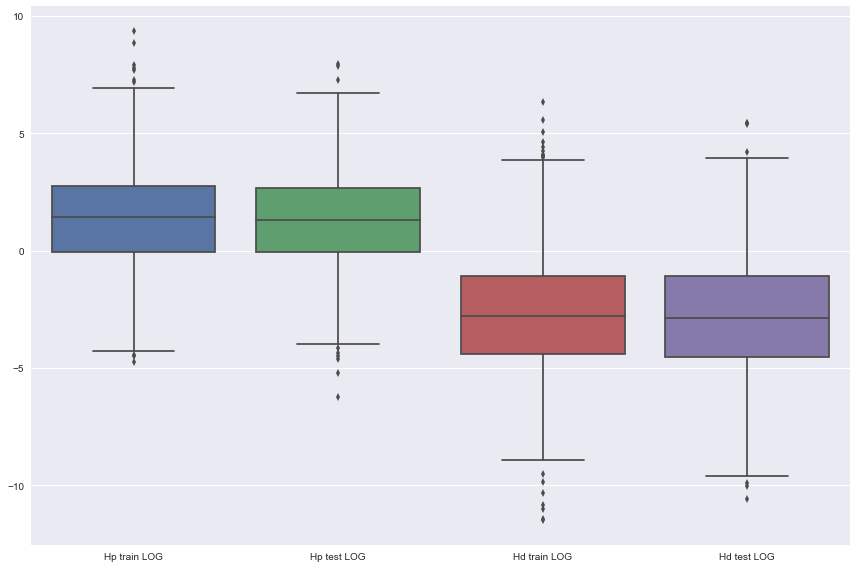

In [6]:
plt.figure(**global_style)

columns_name = "Hp train LOG", "Hp test LOG", "Hd train LOG", "Hd test LOG"
data = [Hp_train_log, Hp_test_log, Hd_train_log, Hd_test_log]

df = pd.DataFrame(np.array(data).T, columns=columns_name)

sns.boxplot(data=df)
plt.tight_layout()

### Visualización conjunta de datos de entrenamiento y de prueba

Otra forma de visualizar si los datos son adecuados es mediante un histograma combinado, si los datos fueran realmente similares, los gráficos deberían superponerse. A continuación se realizan ambos histogramas juntamente con la gráfica correspondiente al KDE (Kernel Density Estimate). Esta última permite visualizar a la distribución como una suma de gaussianas.

Como inicialmente se vio con los boxplot, los datos asociados a los training set y test set son similares en cada clase, y ambas clases tanto $H_d$ como $H_p$ se encuentran ligeramente separadas. Esto permite tener una aproximación del error que se tendría al fijar un umbral de decisión para cualquier valor del $Log(LR)$. A simple vista, el umbral de bayes ($\tau$) que minimiza los errores es aproximadamente -1, ya que es el punto en el que ambas gráficas se intersectan. No obstante aún queda pendiente calibrar la salida, por lo tanto el error puede disminuirse aún más en caso de que la calibración sea efectiva.

In [7]:
def histograma_curso(LR_Hp, LR_Hd):
        
    _, (ax1, ax2) = plt.subplots(2, 1, sharex=True, **global_style)
    
    (bins, *_) = ax1.hist(np.log10(LR_Hp), bins=50, label="$H_p$ cierta")
    ax1.legend()
    ax1.tick_params(labelbottom=True)
    
    x_limits = np.log10(np.min([LR_Hd, LR_Hp])), np.log10(np.max([LR_Hd, LR_Hp]))
    ax1.set_xlim(*x_limits)
    
    y_limits = 0, max(bins)
    ax1.set_ylim(*y_limits)
        
    (bins, *_) = ax2.hist(np.log10(LR_Hd), bins=50, label="$H_d$ cierta")
    ax2.legend()
      
    y_limits = 0, max(bins)
    ax2.set_ylim(*y_limits)

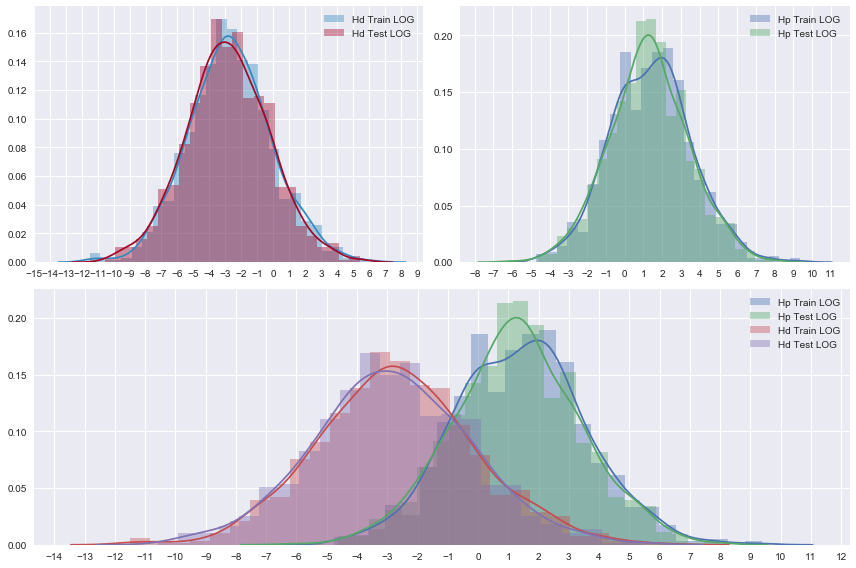

In [8]:
fig = plt.figure(**global_style)

ax1 = plt.subplot(222)
ax2 = plt.subplot(221)
ax3 = plt.subplot(212)

sns.distplot(Hp_train_log, label="Hp Train LOG", ax=ax1)
sns.distplot(Hp_test_log, label="Hp Test LOG", ax=ax1)
ax1.set_xticks(np.arange(-8, 12, 1))
ax1.legend();

sns.distplot(Hd_train_log, label="Hd Train LOG", ax=ax2, color=color_primary)
sns.distplot(Hd_test_log, label="Hd Test LOG", ax=ax2, color=color_primary_alt)
ax2.set_xticks(np.arange(-15, 10, 1))
ax2.legend();

sns.distplot(Hp_train_log, label="Hp Train LOG", ax=ax3)
sns.distplot(Hp_test_log, label="Hp Test LOG", ax=ax3)
sns.distplot(Hd_train_log, label="Hd Train LOG", ax=ax3)
sns.distplot(Hd_test_log, label="Hd Test LOG", ax=ax3)
ax3.set_xticks(np.arange(-14, 13, 1))
ax3.legend()

plt.tight_layout()

### Curva de Calibración

Antes de realizar esta calibración, es importante ver la curva de calibración (*reliability diagram*) donde, en un caso perfectamente calibrado se debería ver la función identidad (representada por la función $f(x) = x$) y, en un caso sin calibración existe un error que es la distancia desde la curva obtenida a la curva identidad.

La curva de calibración tiene en su eje horizontal el valor promedio predicho y en su eje vertical la proporción real. Para realizar esta gráfica es necesario normalizar los datos y tener en cuenta a $H_p$ y a $H_d$ en conjunto. Por eso se crean dos intervalos, uno llamado `total`, que concatena los datos de $H_p$ y $H_d$ y otro llamado `classes` que tiene valor $1$ para los valores asociados a $H_p$ y valor $0$ para los asociados a $H_d$.

Se implementan dos funciones que generan los datos necesarios para graficar las curvas de calibración, la primera es una implementación sub-óptima desarrollada por el estudiante y la segunda es extraida de la libreria `sklearn`, esta última utiliza métodos matriciales mucho más eficientes.

In [9]:
def generate_calibration_curve_manual(classes, scores, bins=10):
    mean_predicted = []
    true_fractions = []
    
    interval = np.linspace(0., 1. + 1e-8, bins + 1)

    for start_bin, end_bin in zip(interval[:-1], interval[1:]):

        total_indexes = np.logical_and(total >= start_bin, total <= end_bin)

        if np.sum(total_indexes) == 0:
            continue

        mean_predicted.append(np.mean(total[total_indexes]))
        true_fractions.append(np.sum(classes[total_indexes]) / np.sum(total_indexes))
    
    return mean_predicted, true_fractions

In [10]:
def generate_calibration_curve_sklearn(y_true, y_prob , bins=10):
    bins = np.linspace(0., 1. + 1e-8, bins + 1)

    binids = np.digitize(y_prob, bins) - 1

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = (bin_true[nonzero] / bin_total[nonzero])
    prob_pred = (bin_sums[nonzero] / bin_total[nonzero])

    return prob_pred, prob_true

Se realiza una prueba sencilla (Benchmarking), para determinar cúal de las soluciones es la más rápida para usarla en el resto del trabajo

In [11]:
bins = 50
total = np.concatenate([Hp_train_log, Hd_train_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))

classes = np.concatenate([np.ones(len(Hp_train_log)), np.zeros(len(total)- len(Hp_train_log))])

%timeit generate_calibration_curve_manual(classes, total, bins=bins)
%timeit generate_calibration_curve_sklearn(classes, total, bins=bins)

3.66 ms ± 640 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
184 µs ± 5.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Por lo visto, la versión utilizada por `sklearn` es un orden de magnitud más rápida por lo tanto se utilizará para el resto del trabajo

In [12]:
def plot_calibration_curve(classes, total, bins, ax, color, label):
    mean_predicted, true_fractions = generate_calibration_curve_sklearn(classes, total, bins=bins)
    ax.plot(mean_predicted, true_fractions, label=label, color=color)
    ax.bar(mean_predicted, true_fractions, width=1/bins/2, color=color, alpha=0.6, align='center')
    ax.legend()
    
    print(f"RMSE with {bins} bins: {np.sum(np.square(1 - np.array(true_fractions)))}")

RMSE with 10 bins: 4.60540241353813
RMSE with 50 bins: 22.246626060829282
RMSE with 10 bins: 4.634715225185278
RMSE with 50 bins: 23.407124028594787


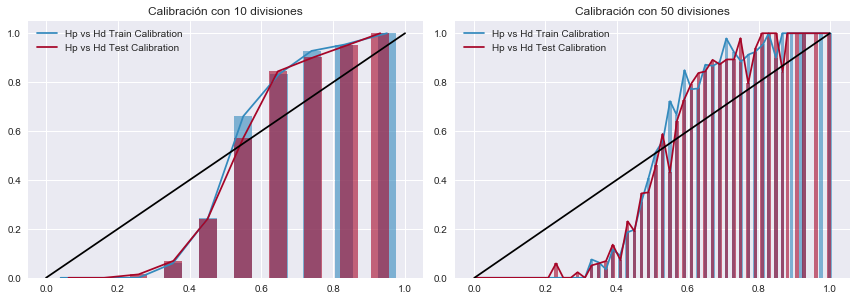

In [13]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

few_bins = 10
many_bins = 50

ax1.set_title(f"Calibración con {few_bins} divisiones")
ax2.set_title(f"Calibración con {many_bins} divisiones")

total = np.concatenate([Hp_train_log, Hd_train_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))

classes = np.concatenate([np.ones(len(Hp_train_log)), np.zeros(len(total)- len(Hp_train_log))])

plot_calibration_curve(classes, total, bins=few_bins, ax=ax1, color=color_primary, label="Hp vs Hd Train Calibration")
plot_calibration_curve(classes, total, bins=many_bins, ax=ax2, color=color_primary, label="Hp vs Hd Train Calibration")

total = np.concatenate([Hp_test_log, Hd_test_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))

classes = np.concatenate([np.ones(len(Hp_test_log)), np.zeros(len(total)- len(Hp_test_log))])

plot_calibration_curve(classes, total, bins=few_bins, ax=ax1, color=color_primary_alt, label="Hp vs Hd Test Calibration")
plot_calibration_curve(classes, total, bins=many_bins, ax=ax2, color=color_primary_alt, label="Hp vs Hd Test Calibration")

ax1.plot(np.linspace(0, 1), np.linspace(0, 1), 'black' )
ax2.plot(np.linspace(0, 1), np.linspace(0, 1), 'black' );

plt.tight_layout()

Se puede ver como el error aumenta a medida que se aumenta la cantidad de divisiones, este error nos servirá para evaluar la eficacia de la posterior calibración. Se tienen estas curvas de referencia y se utilizará dos técnicas de calibración, se compararán las curvas de calibración antes y después de la calibración, si el error se reduce significativamente podemos asumir que la técnica ha sido efectiva, caso contrario, la calibración no fue efectiva

#### Curva APE

La curva APE permite dividir el error total en dos grupos, el error que produce la discriminación en si y el error que produce la calibración. Una vez graficado, es posible conocer el límite inferior de la calibración y determinar cuan desviado se está de ese óptimo.

Como puede verse en la curva APE, existe un considerable error de calibración y la curva APE no se ajusta bien a los valores óptimos.

In [14]:
def calc_ape(LR_Hp, LR_Hd, plo):
    
    with Oct2Py(backend='gnuplot') as oc:
        oc.warning('off','all');
        data = oc.load('2019_ECI_datosMatlabCurso/2019_datos_calibracion_sistemas.mat')
        oc.addpath(oc.genpath('2019_ECI_funcionesMatlabCurso'));
        
        plo = np.arange(-7, 7+0.1, 0.1)
        tar_opt_llrs, nontar_opt_llrs = oc.opt_loglr(LR_Hp, LR_Hd, 'raw', nout=2);
        
        tar_opt_llrs = tar_opt_llrs[0]
        nontar_opt_llrs = nontar_opt_llrs[0]

        clog = oc.cllr(LR_Hp, LR_Hd);

        minclog = oc.cllr(tar_opt_llrs, nontar_opt_llrs);

        Pe = oc.bayes_error_rate(LR_Hp, LR_Hd, plo);
        minPe = oc.bayes_error_rate(tar_opt_llrs, nontar_opt_llrs, plo);
        refPe = oc.bayes_error_rate(0, 0, plo);
        
    return clog, minclog, Pe[0], minPe[0], refPe[0]

Discrimination Loss Sin calibrar: 0.5800257603642126
Calibration Loss Sin calibrar: 0.4349728971774759


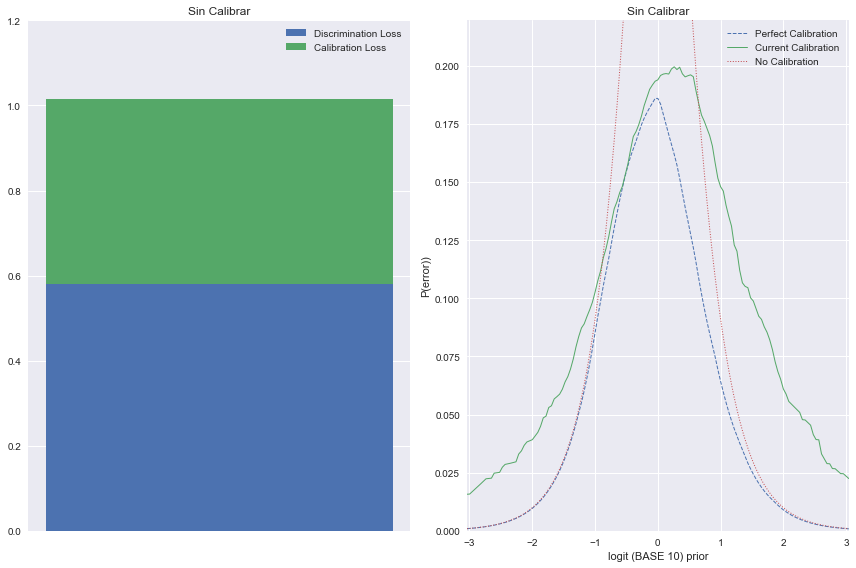

In [15]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plo = np.arange(-7, 7+0.1, 0.1)
x_lim = min(plo / np.log(10)) , max(plo / np.log(10))

clog, minclog, Pe, minPe, refPe = calc_ape(np.log(Hp_test), np.log(Hd_test), plo)
eer = 0
eer = max(eer,max(Pe))
y_lim = 0, eer * 1.1

ax1.bar(0, minclog, label="Discrimination Loss")
ax1.bar(0, clog - minclog, bottom=minclog, label="Calibration Loss")
ax1.set_ylim(0, 1.2)
ax3.set_ylabel('$C_{llr}$')
ax1.set_title("Sin Calibrar")
ax1.set_xticks([], [])
ax1.legend()
print(f"Discrimination Loss Sin calibrar: {minclog}")
print(f"Calibration Loss Sin calibrar: {clog - minclog}")

interval = 1 / np.log(10)
ax2.plot(interval * plo, minPe, label="Perfect Calibration", linestyle="dashed", linewidth=1)
ax2.plot(interval * plo, Pe, label="Current Calibration", linewidth=1)
ax2.plot(interval * plo, refPe, label="No Calibration", linestyle=":", linewidth=1)
ax2.set_ylabel('P(error))')
ax2.set_xlabel('logit (BASE 10) prior')
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_title("Sin Calibrar")
ax2.legend()

plt.tight_layout()

#### Conclusión

Respondiendo a la pregunta:

    ¿Cree que los datos de entrenamiento utilizados en la prueba van a modelar bien la función de calibración a utilizar con los datos de prueba? Razone su respuesta.

Se ha mostrado de diversas formas que los datos de entrenamiento y de prueba comparten características similares, también se llegó a la conclusión de que trabajar los datos en su escala natural puede ser problemático y que debido a eso se utiliza una transformación logarítmica. Se define *a priori* un umbral de decisión en $Log(LR) = -1$ basado en la intersección de los histogramas de los datos para minimizar el error. Así mismo, gracias a la curva APE, se sabe que la calibración obtenida hasta el momento puede mejorarse reduciendo así el error que introduce una mala calibración.

### Calibración mediante regresión logística (o calibración Platt)

Habiendo detectado la necesidad de un método de calibración, se comienza utilizando la calibración Platt, que se basa en ajustar una regresión logística.

Al final de esta sección se responderán las siguientes preguntas:

Pregunta 1: **Observe la función de calibración obtenida. Coméntela con sus compañeros y el profesor. ¿Cuál cree que son sus principales ventajas e inconvenientes?**

Pregunta 2: **Comente el efecto de la calibración en las Tippett obtenidas.**

Pregunta 3: **Comente el efecto de la calibración en las APEs obtenidas.**

#### Cálculo de datos

Para realizar el cálculo de los nuevos $LR$s calibrados, se utiliza la función `calibracion_lineal_curso` de los archivos provistos. Para ello se ejecuta un Engine de Octave para poder ejecutar los comandos y finalmente se guardan en dos variables de Python

In [16]:
with Oct2Py(backend='gnuplot') as oc:
    oc.warning('off','all');
    data = oc.load('2019_ECI_datosMatlabCurso/2019_datos_calibracion_sistemas.mat')
    oc.addpath(oc.genpath('2019_ECI_funcionesMatlabCurso'));
    Hp_calibrado_lineal, Hd_calibrado_lineal = oc.calibracion_lineal_curso(
                                                  data['sistema4_Hp_train'], 
                                                  data['sistema4_Hd_train'],
                                                  data['sistema4_Hp_test'],
                                                  data['sistema4_Hd_test'],
                                                  nout=2
                                                  );

Training with a conservative threshold...
Convergence condition 0.17144
Convergence condition 0.31689
Convergence condition 0.088272
Convergence condition 0.055171
Convergence condition 0.036932
Convergence condition 0.0037129
Convergence condition 0.0049039
Convergence condition 3.3518e-05
Convergence condition 7.3839e-05
Convergence condition 5.3932e-09
Convergence condition 1.6365e-08
Convergence condition 6.7724e-15
Done!


#### Transformación de datos

Como se mencionó anteriormente, es conveniente transformar los datos a una escala logarítmica para facilitar su manipulación e interpretación.

In [17]:
Hp_calibrado_lineal = Hp_calibrado_lineal[0]
Hd_calibrado_lineal = Hd_calibrado_lineal[0]
Hp_calibrado_lineal_log = np.log10(Hp_calibrado_lineal)
Hd_calibrado_lineal_log = np.log10(Hd_calibrado_lineal)

#### Box Plots

Una manera rápida y visual de ver como cambiaron los estadísticos descriptivos luego de realizar el proceso de calibración es mediante los Box Plots. Ya que en estos pueden verse los cuartiles, la mediana y también la presencia de valores atípicos

En este caso se ve como el efecto más notorio fue la reducción de la varianza, los datos ahora se encuentran ubicados en un intervalo mucho más pequeño, su rango intercuartil también se vio reducido y, si bien su mediana está en una posición similar a la original, en ambos casos se produjo un "acercamiento" hacia el $0$

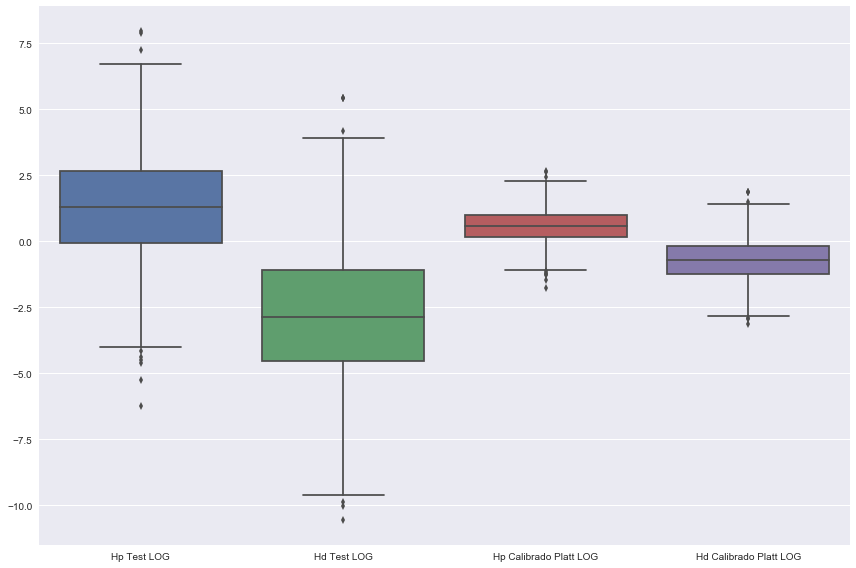

In [18]:
plt.figure(**global_style)

columns_name = "Hp Test LOG", "Hd Test LOG", "Hp Calibrado Platt LOG", "Hd Calibrado Platt LOG"
data = [Hp_test_log, Hd_test_log, Hp_calibrado_lineal_log, Hd_calibrado_lineal_log]

df = pd.DataFrame(np.array(data).T, columns=columns_name)

sns.boxplot(data=df)
plt.tight_layout()

#### Histogramas

Para no dejarse engañar por los box plots, que pueden mostrar perspectiva sesgadas cuando hay pocos datos, es necesario también ver los histogramas asociados. En este caso se superponen el original y el nuevo (Test vs Calibrado) y se muestra la diferencia entre las intersecciones originales y las calibradas ($H_p$ vs $H_d$)

Cuando uno compara el histograma original con el calibrado de cada dataset, puede verse el mismo fenómeno que estaba presente en los Box Plots, una reducción de la varianza, lo que produce histogramas con una dispersión mucho más pequeña. Sin embargo, al comprar los histogramas calibrados y los histogramas sin calibrar, la forma se mantiene y sólo ha cambiado el valor de su escala, este es un fenómeno común cuando se realizan transformaciones lineales.

Si bien la forma calibrada difiere bastante de la original, al ser una transformación lineal, la mayoría de sus propiedades se mantienen. En este caso el umbral de Bayes se encuentra aproximadamente en $0$, a diferencia del original que se encontraba en $-1$

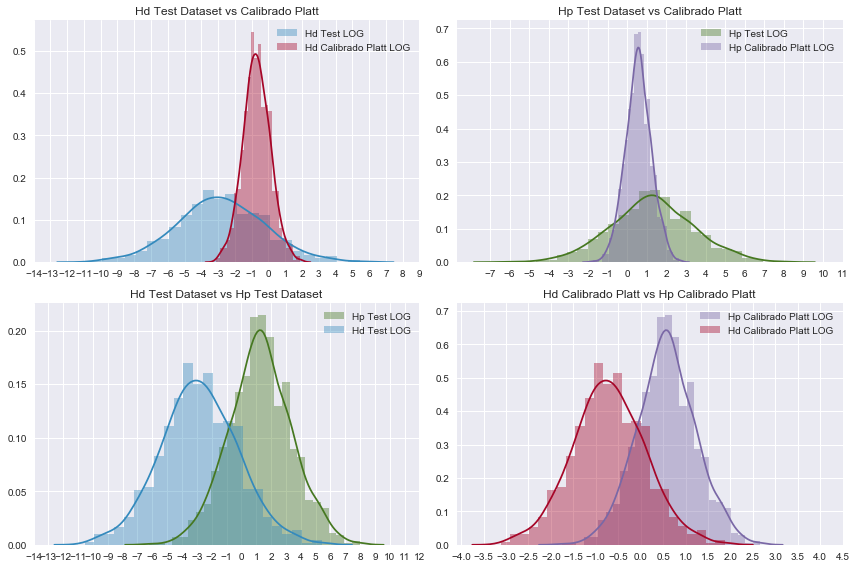

In [19]:
fig = plt.figure(**global_style)

ax1 = plt.subplot(222)
ax2 = plt.subplot(221)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

sns.distplot(Hp_test_log, label="Hp Test LOG", ax=ax1, color=color_secondary_alt)
sns.distplot(Hp_calibrado_lineal_log, label="Hp Calibrado Platt LOG", ax=ax1, color=color_secondary)
ax1.set_xticks(np.arange(-7, 12, 1))
ax1.legend();
ax1.set_title('Hp Test Dataset vs Calibrado Platt')

sns.distplot(Hd_test_log, label="Hd Test LOG", ax=ax2, color=color_primary)
sns.distplot(Hd_calibrado_lineal_log, label="Hd Calibrado Platt LOG", ax=ax2, color=color_primary_alt)
ax2.set_xticks(np.arange(-14, 10, 1))
ax2.legend();
ax2.set_title('Hd Test Dataset vs Calibrado Platt')

sns.distplot(Hp_test_log, label="Hp Test LOG", ax=ax3, color=color_secondary_alt)
sns.distplot(Hd_test_log, label="Hd Test LOG", ax=ax3, color=color_primary)
ax3.set_xticks(np.arange(-14, 13, 1))
ax3.legend()
ax3.set_title('Hd Test Dataset vs Hp Test Dataset')

sns.distplot(Hp_calibrado_lineal_log, label="Hp Calibrado Platt LOG", ax=ax4, color=color_secondary)
sns.distplot(Hd_calibrado_lineal_log, label="Hd Calibrado Platt LOG", ax=ax4, color=color_primary_alt)
ax4.set_xticks(np.arange(-4, 5, 0.5))
ax4.legend()
ax4.set_title('Hd Calibrado Platt vs Hp Calibrado Platt')

plt.tight_layout()

#### Curva de Calibración

Las curvas de calibración en ambos casos son idénticas, esto se debe que al normalizarse los datos, si hubo una transformación lineal, los datos serán idénticos, por lo que esta curva no nos aporta información significativa y parecería que en primera instancia no se ha logrado el efecto deseado. Sin embargo esto debe contrastarse con otras medidas como se verá a continuación.

RMSE with 10 bins: 4.634715225185278
RMSE with 50 bins: 23.407124028594787
RMSE with 10 bins: 4.634715225185278
RMSE with 50 bins: 23.407124028594787


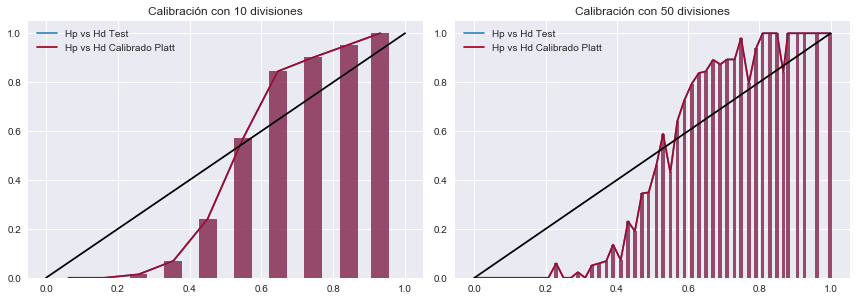

In [20]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

few_bins = 10
many_bins = 50

ax1.set_title(f"Calibración con {few_bins} divisiones")
ax2.set_title(f"Calibración con {many_bins} divisiones")

total = np.concatenate([Hp_test_log, Hd_test_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))

classes = np.concatenate([np.ones(len(Hp_test_log)), np.zeros(len(total)- len(Hp_test_log))])

plot_calibration_curve(classes, total, bins=few_bins, ax=ax1, color=color_primary, label="Hp vs Hd Test")
plot_calibration_curve(classes, total, bins=many_bins, ax=ax2, color=color_primary, label="Hp vs Hd Test")

total = np.concatenate([Hp_calibrado_lineal_log, Hd_calibrado_lineal_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))

classes = np.concatenate([np.ones(len(Hp_calibrado_lineal_log)), np.zeros(len(total)- len(Hp_calibrado_lineal_log))])

plot_calibration_curve(classes, total, bins=few_bins, ax=ax1, color=color_primary_alt, label="Hp vs Hd Calibrado Platt")
plot_calibration_curve(classes, total, bins=many_bins, ax=ax2, color=color_primary_alt, label="Hp vs Hd Calibrado Platt")

ax1.plot(np.linspace(0, 1), np.linspace(0, 1), 'black' )
ax2.plot(np.linspace(0, 1), np.linspace(0, 1), 'black' );

plt.tight_layout()

#### Entrada / Salida

Una forma muy útil de visualizar la técnica es construir una gráfica de entrada y Salida, es decir, una gráfica que permita relacionar los valores no calibrados con los calibrados.

Como se supuso inicialmente con los histogramaas, puede verse como la gráfica es una transformación lineal (en el dominio logarítmico) que lleva los datos de un intervalo amplio a uno más reducido. En el caso de la escala logarítmica puede verse como se pasa de tener un rango de $17.5$ a tener uno de $6$. Concentrando de esta forma mucho más los datos.

El hecho de que esta transformación pueda expresarse como una recta (en un dominio logarítmico) implica que su cálculo es muy sencillo y que requiere pocos recursos computacionales.

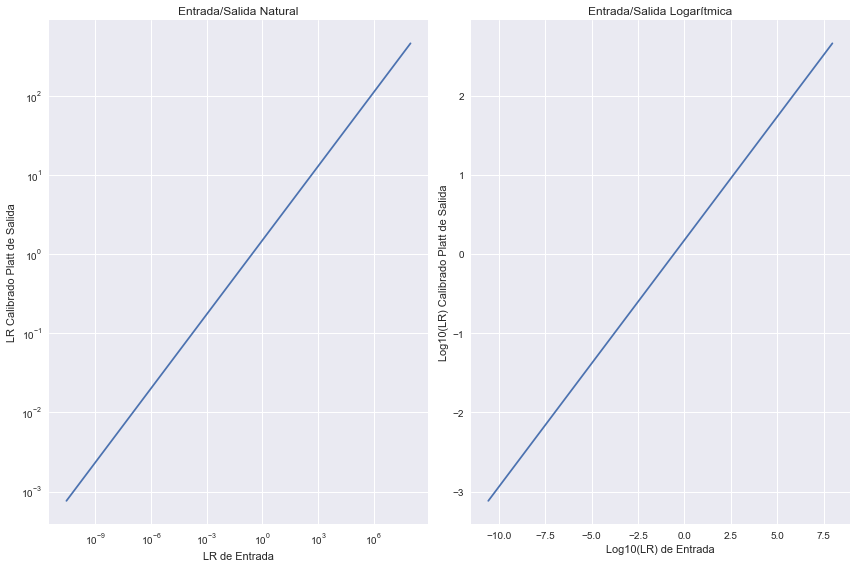

In [21]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.sort(np.concatenate([Hd_test, Hp_test])), np.sort(np.concatenate([Hd_calibrado_lineal, Hp_calibrado_lineal])))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('LR de Entrada')
ax1.set_ylabel('LR Calibrado Platt de Salida')
ax1.set_title('Entrada/Salida Natural')

ax2.plot(np.sort(np.concatenate([Hd_test_log, Hp_test_log])), np.sort(np.concatenate([Hd_calibrado_lineal_log, Hp_calibrado_lineal_log])))
ax2.set_xlabel('Log10(LR) de Entrada')
ax2.set_ylabel('Log10(LR) Calibrado Platt de Salida')
ax2.set_title('Entrada/Salida Logarítmica')

plt.tight_layout()

### Curva ROC y DET

Inicialmente las técnicas de calibración no deberían afectar el poder discriminatorio del clasificador. No se dedicará mucho tiempo a este aspecto pero para demostrar que no ha habido cambios en este ámbito se muestra la curva ROC y la curva DET. Si hubiera cambios en el poder de discriminación, ambas curvas deberían ser distintas antes y después de la calibración, si son iguales, no ha habido diferencias.

Como puede observarse tanto en la curva ROC como en la DET, no hubo cambios, el poder discriminativo del clasificador no se vio modificado por el proceso de calibración.

In [22]:
def plot_roc_curve(classes, total, label, ax):
    fpr, tpr, _ = roc_curve(classes, total)
    roc_auc = auc(fpr, tpr)
    
    ax.plot(fpr, tpr, label=f'{label} (area = %0.3f)' % roc_auc)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Curva ROC')
    ax.legend()

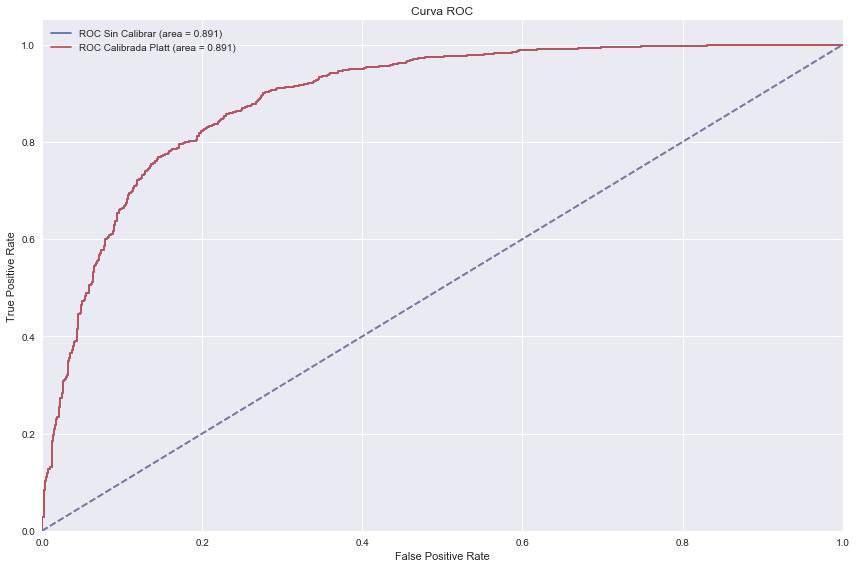

In [23]:
fig, ax = plt.subplots(**global_style)

total = np.concatenate([Hp_test_log, Hd_test_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))
classes = np.concatenate([np.ones(len(Hp_test_log)), np.zeros(len(total)- len(Hp_test_log))])
plot_roc_curve(classes, total, label='ROC Sin Calibrar', ax=ax)


total = np.concatenate([Hp_calibrado_lineal_log, Hd_calibrado_lineal_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))
classes = np.concatenate([np.ones(len(Hp_calibrado_lineal_log)), np.zeros(len(total)- len(Hp_calibrado_lineal_log))])
plot_roc_curve(classes, total, label='ROC Calibrada Platt', ax=ax)

plt.tight_layout()

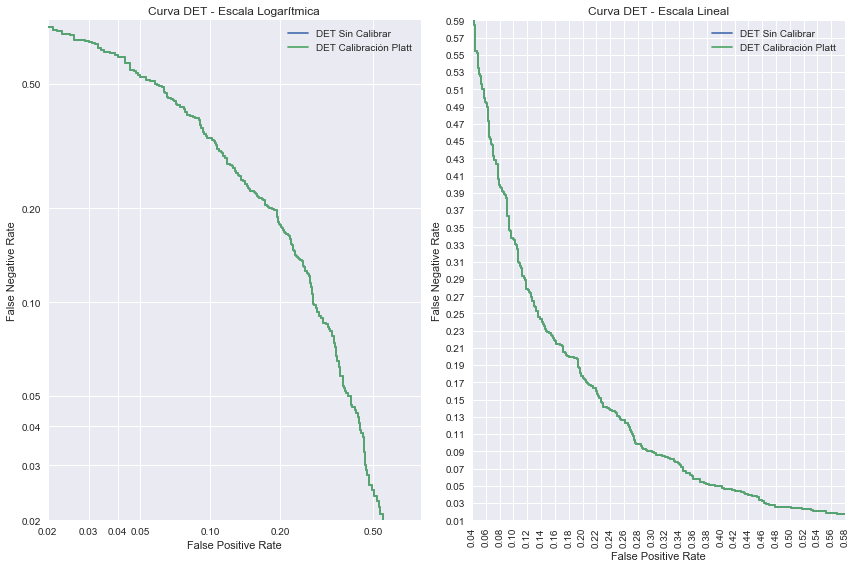

In [24]:
fig = plt.figure(**global_style)

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

total = np.concatenate([Hp_test_log, Hd_test_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))
classes = np.concatenate([np.ones(len(Hp_test_log)), np.zeros(len(total)- len(Hp_test_log))])

fpr1, tpr1, _ = roc_curve(classes, total)
fns1 = tpr1[-1] - tpr1

total = np.concatenate([Hp_calibrado_lineal_log, Hd_calibrado_lineal_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))
classes = np.concatenate([np.ones(len(Hp_calibrado_lineal_log)), np.zeros(len(total)- len(Hp_calibrado_lineal_log))])

fpr2, tpr2, _ = roc_curve(classes, total)
fns2 = tpr2[-1] - tpr2


ax.plot(fpr1, fns1, label="DET Sin Calibrar")
ax.plot(fpr2, fns2, label="DET Calibración Platt")
ax.set_xlim([0.05, .8])
ax.set_ylim([0.05, .8])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ticks_to_use = [0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5]
ax.set_yscale('log')
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(ticks_to_use)
ax.set_yticks(ticks_to_use)
ax.set_title('Curva DET - Escala Logarítmica')
ax.legend()

ax2.plot(fpr1, fns1, label="DET Sin Calibrar")
ax2.plot(fpr2, fns2, label="DET Calibración Platt")
ax2.set_xlim([0.04, 0.55])
ax2.set_ylim([0.01, 0.55])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('False Negative Rate')
ax2.set_yticks(np.arange(0.01, 0.6, 0.02))
ax2.set_xticks(np.arange(0.04, 0.6, 0.02))
ax2.set_title('Curva DET - Escala Lineal')
ax2.legend()

plt.xticks(rotation='vertical')

plt.tight_layout()

#### Curva APE

La curva APE nos permitirá ver en detalle si efectivamente se ha podido o no reducir el error de la calibración ya que en esta curva puede visualizarse tanto el error por discriminación como el error por calibración y comparar el estado actual con el óptimo teórico.

Como puede verse, el error de calibración se ha reducido al mínimo, reduciéndose de $0.44$ a $0.02$, una mejora sustancial. Y al ver la curva APE también se puede concluir que hay poco lugar para la mejora a partir de este punto. Si se quisiera mejorar aún más el modelo, debería mejorarse el poder discriminativo del clasificador.

Discrimination Loss Sin calibrar: 0.5800257603642126
Calibration Loss Sin calibrar: 0.4349728971774759
Discrimination Loss Calibración Platt: 0.5800257603642126
Calibration Loss Calibración Platt: 0.02016072892791143


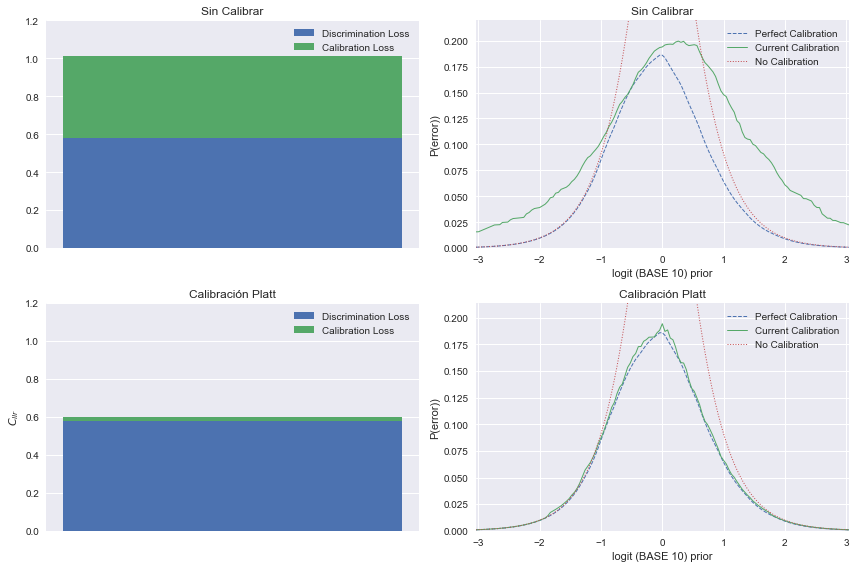

In [25]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plo = np.arange(-7, 7+0.1, 0.1)
x_lim = min(plo / np.log(10)) , max(plo / np.log(10))

clog, minclog, Pe, minPe, refPe = calc_ape(np.log(Hp_test), np.log(Hd_test), plo)
eer = 0
eer = max(eer,max(Pe))
y_lim = 0, eer * 1.1

ax1.bar(0, minclog, label="Discrimination Loss")
ax1.bar(0, clog - minclog, bottom=minclog, label="Calibration Loss")
ax1.set_ylim(0, 1.2)
ax3.set_ylabel('$C_{llr}$')
ax1.set_title("Sin Calibrar")
ax1.set_xticks([], [])
ax1.legend()
print(f"Discrimination Loss Sin calibrar: {minclog}")
print(f"Calibration Loss Sin calibrar: {clog - minclog}")

interval = 1 / np.log(10)
ax2.plot(interval * plo, minPe, label="Perfect Calibration", linestyle="dashed", linewidth=1)
ax2.plot(interval * plo, Pe, label="Current Calibration", linewidth=1)
ax2.plot(interval * plo, refPe, label="No Calibration", linestyle=":", linewidth=1)
ax2.set_ylabel('P(error))')
ax2.set_xlabel('logit (BASE 10) prior')
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_title("Sin Calibrar")
ax2.legend()

clog, minclog, Pe, minPe, refPe = calc_ape(np.log(Hp_calibrado_lineal), np.log(Hd_calibrado_lineal), plo)
eer = 0
eer = max(eer,max(Pe))
y_lim = 0, eer * 1.1

ax3.bar(0, minclog, label="Discrimination Loss")
ax3.bar(0, clog - minclog, bottom=minclog, label="Calibration Loss")
ax3.set_ylim(0, 1.2)
ax3.set_ylabel('$C_{llr}$')
ax3.set_title("Calibración Platt")
ax3.set_xticks([], [])
ax3.legend()
print(f"Discrimination Loss Calibración Platt: {minclog}")
print(f"Calibration Loss Calibración Platt: {clog - minclog}")

interval = 1 / np.log(10)
ax4.plot(interval * plo, minPe, label="Perfect Calibration", linestyle="dashed", linewidth=1)
ax4.plot(interval * plo, Pe, label="Current Calibration", linewidth=1)
ax4.plot(interval * plo, refPe, label="No Calibration", linestyle=":", linewidth=1)
ax4.set_xlim(x_lim)
ax4.set_ylim(y_lim)
ax4.set_title("Calibración Platt")
ax4.set_ylabel('P(error))')
ax4.set_xlabel('logit (BASE 10) prior')
ax4.legend()

plt.tight_layout()

#### Conclusiones

La calibración Platt permite escalar los valores de los scores de manera que se mantienen muchas de sus propiedades y viendose desde una escala logarítmica, la transformación es lineal. Esto tiene sus ventajas y desventajas, como se comentó, es muy sencilla de calcular y probablemente se pueda escalar sin mayores dificultades pero, parecería asignar valores cada vez mayores en valor absoluto en función de su entrada. 

Es decir, dada un entrada lo suficientemente grande, el valor de salida también lo será, esto daría a entender que la fuerza de la evidencia es bastante subjetiva a los valores de entrada y que en realidad no se posee un techo o un piso sobre los valores que pueden darse. Esta manera de representar los valores de salida no es la adecuada ya que cada clasificador tiene una confianza asociada y deberia poder determinarse un umbral de decisión para sus salidas (en el caso de clases binarias) que permita distinguir entre tres zonas, la de decisión por una clase, la de no-decisión y la de decisión por otra clase.

La calibración Platt no permite visualmente identificar cual sería un buen lugar para ubicar los umbrales de decisión para distinguir entre las tres zonas mencionadas y parecería que a priori todos los puntos son factibles cuando esto no es así.

El siguiente método que se considerará es la Calibración PAV donde varios de estos aspectos se resuelven de una manera mucho más adecuada.

### Calibración por regresión isotónica PAV

La calibración PAV utiliza una regresión isotónica en lugar de una logística. Para calcular los valores calibrados se utiliza la función provista en el material llamada `calibracon_PAV_curso`. 

Al final de esta sección se responden las siguientes preguntas:

Pregunta 1: **Comente el efecto de la calibración en las Tippett obtenidas.**

Pregunta 2: **Comente el efecto de la calibración en las APEs obtenidas.**

In [26]:
with Oct2Py(backend='gnuplot') as oc:
    oc.warning('off','all')
    data = oc.load('2019_ECI_datosMatlabCurso/2019_datos_calibracion_sistemas.mat')
    oc.addpath(oc.genpath('2019_ECI_funcionesMatlabCurso'))
    Hp_calibrado_PAV, Hd_calibrado_PAV = oc.calibracion_PAV_curso(
                                            data['sistema4_Hp_train'], 
                                            data['sistema4_Hd_train'], 
                                            data['sistema4_Hp_test'], 
                                            data['sistema4_Hd_test'], 
                                            nout=2
                                            )

#### Transformación de Datos

Una vez calculado los datos se transforman de manera logarítmica (base10) para trabajar más facilmente con ellos.

In [27]:
Hp_calibrado_PAV = Hp_calibrado_PAV[0]
Hd_calibrado_PAV = Hd_calibrado_PAV[0]
Hp_calibrado_PAV_log = np.log10(Hp_calibrado_PAV)
Hd_calibrado_PAV_log = np.log10(Hd_calibrado_PAV)

#### Box Plots

Al igual que en la calibración Platt, el efecto de la calibración PAV produjo una gran reducción en la dispersión de los datos y en este caso la mediana se ha desplazado bastante con respecto a su valor original. Otro detalle importante es que se reduce la cantidad de valores atípicos, esto puede sugerir que la técnica ha realizado una conversión no-lineal en los datos. Para inspeccionar esto en más detalle debe verse el histograma

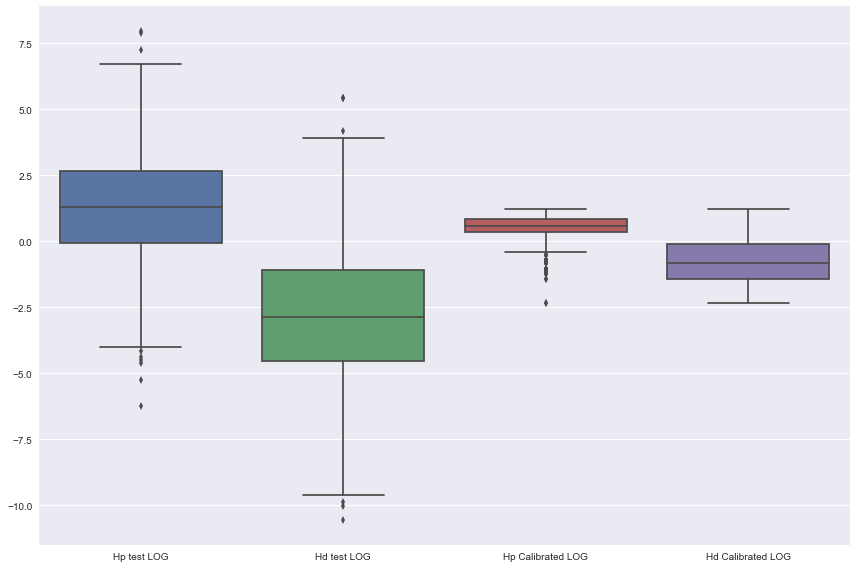

In [28]:
plt.figure(**global_style)

columns_name = "Hp test LOG", "Hd test LOG", "Hp Calibrated LOG", "Hd Calibrated LOG"
data = [Hp_test_log, Hd_test_log, Hp_calibrado_PAV_log, Hd_calibrado_PAV_log]

df = pd.DataFrame(np.array(data).T, columns=columns_name)

sns.boxplot(data=df)
plt.tight_layout()

#### Histogramas

Al comprar el histograma de los datos originales con el de los datos calibrados se puede ver como se han transformado los datos de una manera radical, la transformación es evidentemente no lineal e incluso ha generado regiones sin datos. Estos "huecos" han hecho que al calcular el KDE se obtengan distribuciones multimodales, las cuales dificultan significativamente el cálculo de los Falsos Positivos y Falsos Negativos y por ende, hacen más compleja la elección de un umbral de decisión.

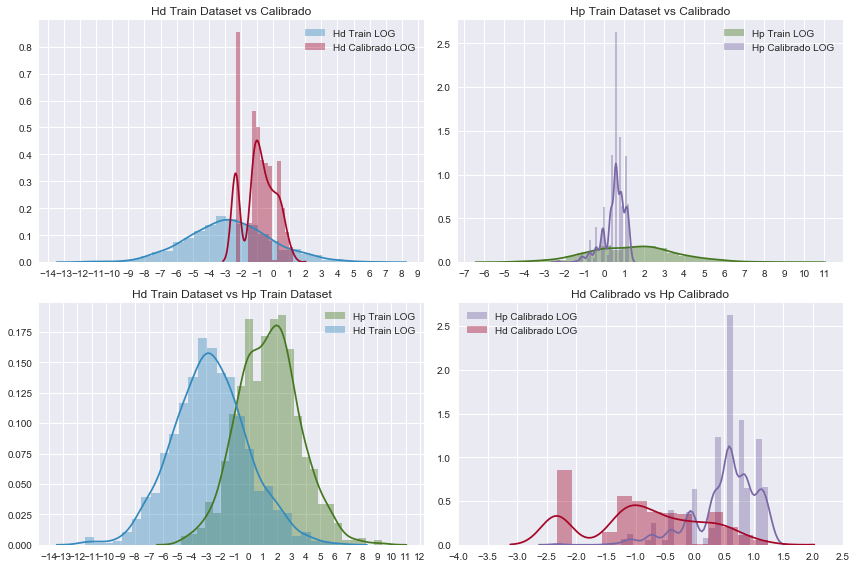

In [29]:
fig = plt.figure(**global_style)

ax1 = plt.subplot(222)
ax2 = plt.subplot(221)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

sns.distplot(Hp_train_log, label="Hp Train LOG", ax=ax1, color=color_secondary_alt)
sns.distplot(Hp_calibrado_PAV_log, label="Hp Calibrado LOG", ax=ax1, color=color_secondary)
ax1.set_xticks(np.arange(-7, 12, 1))
ax1.legend();
ax1.set_title('Hp Train Dataset vs Calibrado')

sns.distplot(Hd_train_log, label="Hd Train LOG", ax=ax2, color=color_primary)
sns.distplot(Hd_calibrado_PAV_log, label="Hd Calibrado LOG", ax=ax2, color=color_primary_alt)
ax2.set_xticks(np.arange(-14, 10, 1))
ax2.legend();
ax2.set_title('Hd Train Dataset vs Calibrado')

sns.distplot(Hp_train_log, label="Hp Train LOG", ax=ax3, color=color_secondary_alt)
sns.distplot(Hd_train_log, label="Hd Train LOG", ax=ax3, color=color_primary)
ax3.set_xticks(np.arange(-14, 13, 1))
ax3.legend()
ax3.set_title('Hd Train Dataset vs Hp Train Dataset')

sns.distplot(Hp_calibrado_PAV_log, label="Hp Calibrado LOG", ax=ax4, color=color_secondary)
sns.distplot(Hd_calibrado_PAV_log, label="Hd Calibrado LOG", ax=ax4, color=color_primary_alt)
ax4.set_xticks(np.arange(-4, 3, 0.5))
ax4.legend()
ax4.set_title('Hd Calibrado vs Hp Calibrado')

plt.tight_layout()

#### Curvas de Calibración

En esta oportunidad las curvas de calibración son diferentes, y si se utiliza el RMSE de cada punto a la recta identidad, puede verse que tanto con 10 divisiones como con 15 los valores del error son menores para los datos calibrados, si bien la reducción no es significativa en este caso. Otro detalle importante es que ahora todos los puntos han quedado debajo de la curva. Esto quiere decir que siempre se pronostica en una proporción menor a la real.

RMSE with 10 bins: 4.634715225185278
RMSE with 15 bins: 6.965877700021496
RMSE with 10 bins: 4.294150251902032
RMSE with 15 bins: 5.785222005199874


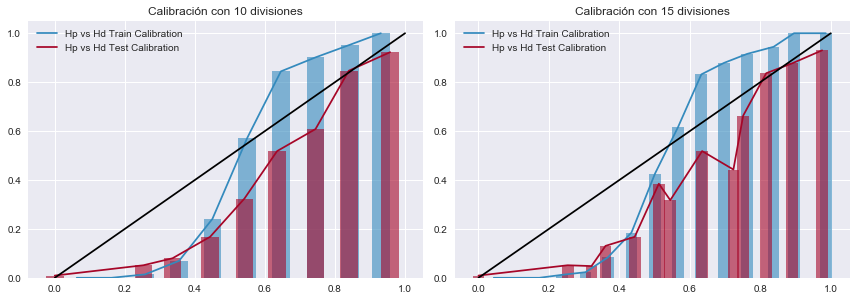

In [30]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

few_bins = 10
many_bins = 15

ax1.set_title(f"Calibración con {few_bins} divisiones")
ax2.set_title(f"Calibración con {many_bins} divisiones")

total = np.concatenate([Hp_test_log, Hd_test_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))

classes = np.concatenate([np.ones(len(Hp_test_log)), np.zeros(len(total)- len(Hp_test_log))])

plot_calibration_curve(classes, total, bins=few_bins, ax=ax1, color=color_primary, label="Hp vs Hd Train Calibration")
plot_calibration_curve(classes, total, bins=many_bins, ax=ax2, color=color_primary, label="Hp vs Hd Train Calibration")

total = np.concatenate([Hp_calibrado_PAV_log, Hd_calibrado_PAV_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))

classes = np.concatenate([np.ones(len(Hp_calibrado_PAV_log)), np.zeros(len(total)- len(Hd_calibrado_PAV_log))])

plot_calibration_curve(classes, total, bins=few_bins, ax=ax1, color=color_primary_alt, label="Hp vs Hd Test Calibration")
plot_calibration_curve(classes, total, bins=many_bins, ax=ax2, color=color_primary_alt, label="Hp vs Hd Test Calibration")

ax1.plot(np.linspace(0, 1), np.linspace(0, 1), 'black' )
ax2.plot(np.linspace(0, 1), np.linspace(0, 1), 'black' );

plt.tight_layout()

#### Entrada / Salida

La curva de entrada y salida es una función de tipo escalón en el dominio logarítmico y tiene una característica muy interesante que es que tiene un valor mínimo y un valor máximo, a partir de los cuales la función es constante. Esto permite interpretar los límites de la fuerza de este clasificador (en escala logarítmica), que va desde aproximadamente $-2.35$ a $1.25$. Así mismo, los valores donde se tienen estos escalores permiten identificar facilmente umbrales de decisión posibles con una clara interpretación.

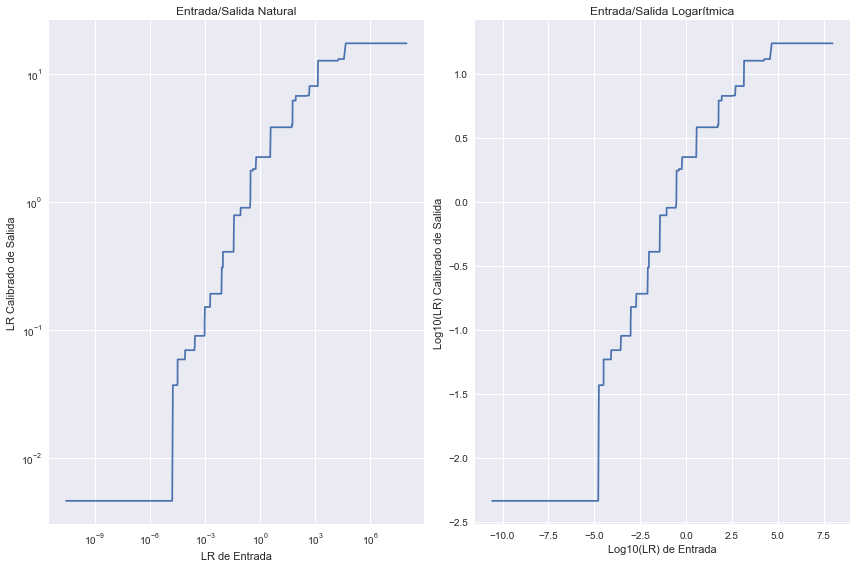

In [31]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.sort(np.concatenate([Hd_test, Hp_test])), np.sort(np.concatenate([Hd_calibrado_PAV, Hp_calibrado_PAV])))
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('LR de Entrada')
ax1.set_ylabel('LR Calibrado de Salida')
ax1.set_title('Entrada/Salida Natural')

ax2.plot(np.sort(np.concatenate([Hd_test_log, Hp_test_log])), np.sort(np.concatenate([Hd_calibrado_PAV_log, Hp_calibrado_PAV_log])))
ax2.set_xlabel('Log10(LR) de Entrada')
ax2.set_ylabel('Log10(LR) Calibrado de Salida')
ax2.set_title('Entrada/Salida Logarítmica')

plt.tight_layout()

#### Curva ROC y DET

Como se demostró para la calibración Platt, en este caso también puede verse como la calibración PAV no tiene ningún efecto en el poder discriminativo del clasificador, observando tanto la curva ROC como la DET.

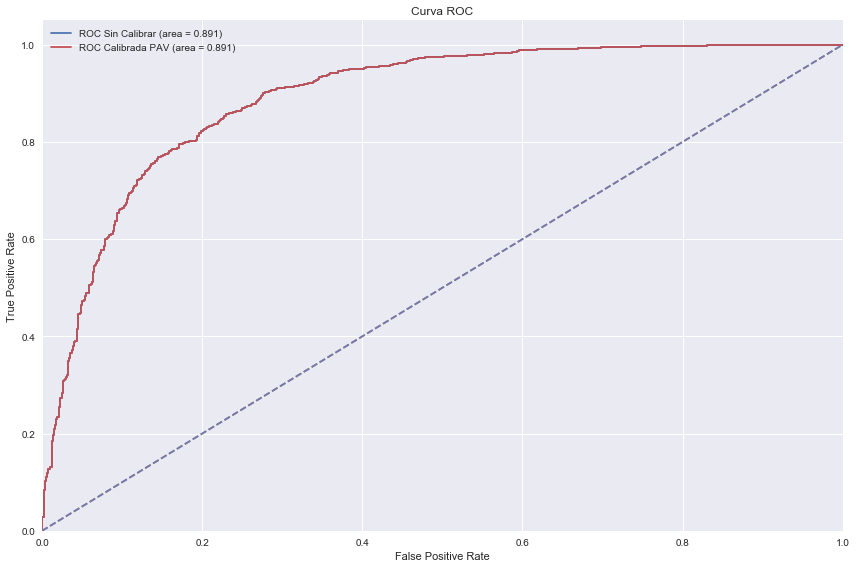

In [32]:
fig, ax = plt.subplots(**global_style)

total = np.concatenate([Hp_test_log, Hd_test_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))
classes = np.concatenate([np.ones(len(Hp_train_log)), np.zeros(len(total)- len(Hp_train_log))])
plot_roc_curve(classes, total, label='ROC Sin Calibrar', ax=ax)


total = np.concatenate([Hp_calibrado_PAV_log, Hd_calibrado_PAV_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))
classes = np.concatenate([np.ones(len(Hp_calibrado_PAV_log)), np.zeros(len(total)- len(Hp_calibrado_PAV_log))])
plot_roc_curve(classes, total, label='ROC Calibrada PAV', ax=ax)

plt.legend()

plt.tight_layout()

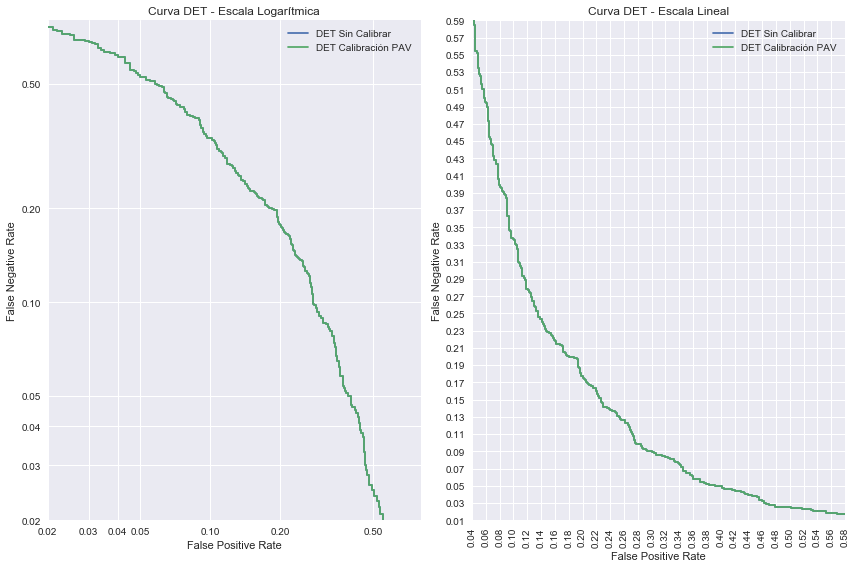

In [33]:
fig = plt.figure(**global_style)

ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

total = np.concatenate([Hp_calibrado_PAV_log, Hd_calibrado_PAV_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))
classes = np.concatenate([np.ones(len(Hp_calibrado_PAV_log)), np.zeros(len(total)- len(Hp_calibrado_PAV_log))])

fpr1, tpr1, _ = roc_curve(classes, total)
fns1 = tpr1[-1] - tpr1

total = np.concatenate([Hp_calibrado_lineal_log, Hd_calibrado_lineal_log])
total = (total - np.min(total)) / (np.max(total) - np.min(total))
classes = np.concatenate([np.ones(len(Hp_calibrado_lineal_log)), np.zeros(len(total)- len(Hp_calibrado_lineal_log))])

fpr2, tpr2, _ = roc_curve(classes, total)
fns2 = tpr2[-1] - tpr2

ax.plot(fpr1, fns1, label="DET Sin Calibrar")
ax.plot(fpr2, fns2, label="DET Calibración PAV")
ax.set_xlim([0.05, .8])
ax.set_ylim([0.05, .8])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ticks_to_use = [0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.5]
ax.set_yscale('log')
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(ticks_to_use)
ax.set_yticks(ticks_to_use)
ax.set_title('Curva DET - Escala Logarítmica')
ax.legend()

ax2.plot(fpr1, fns1, label="DET Sin Calibrar")
ax2.plot(fpr2, fns2, label="DET Calibración PAV")
ax2.set_xlim([0.04, 0.55])
ax2.set_ylim([0.01, 0.55])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('False Negative Rate')
ax2.set_yticks(np.arange(0.01, 0.6, 0.02))
ax2.set_xticks(np.arange(0.04, 0.6, 0.02))
ax2.set_title('Curva DET - Escala Lineal')
ax2.legend()

plt.xticks(rotation='vertical')

plt.tight_layout()

#### Curvas APE

En esta oportunidad también se ve una reducción notoria en el error de calibración, yendo en este caso desde $0.43$ a $0.019$. También puede verse como la curva APE se ajustó a la de calibración perfecta.

Discrimination Loss Sin calibrar: 0.5800257603642126
Calibration Loss Sin calibrar: 0.4349728971774759
Discrimination Loss Calibración PAV: 0.5800257603642126
Calibration Loss Calibración PAV: 0.019699545680709085


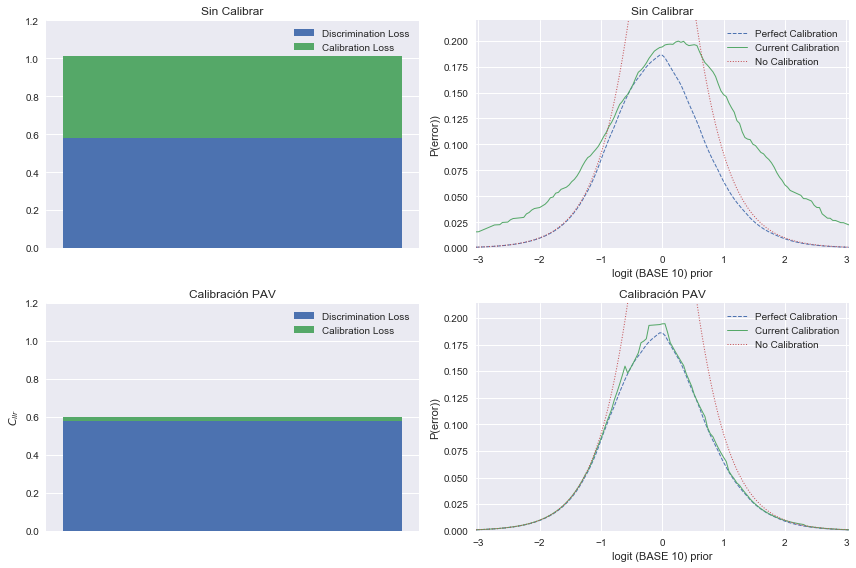

In [34]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plo = np.arange(-7, 7+0.1, 0.1)
x_lim = min(plo / np.log(10)) , max(plo / np.log(10))

clog, minclog, Pe, minPe, refPe = calc_ape(np.log(Hp_test), np.log(Hd_test), plo)
eer = 0
eer = max(eer,max(Pe))
y_lim = 0, eer * 1.1

ax1.bar(0, minclog, label="Discrimination Loss")
ax1.bar(0, clog - minclog, bottom=minclog, label="Calibration Loss")
ax1.set_ylim(0, 1.2)
ax3.set_ylabel('$C_{llr}$')
ax1.set_title("Sin Calibrar")
ax1.set_xticks([], [])
ax1.legend()
print(f"Discrimination Loss Sin calibrar: {minclog}")
print(f"Calibration Loss Sin calibrar: {clog - minclog}")

interval = 1 / np.log(10)
ax2.plot(interval * plo, minPe, label="Perfect Calibration", linestyle="dashed", linewidth=1)
ax2.plot(interval * plo, Pe, label="Current Calibration", linewidth=1)
ax2.plot(interval * plo, refPe, label="No Calibration", linestyle=":", linewidth=1)
ax2.set_ylabel('P(error))')
ax2.set_xlabel('logit (BASE 10) prior')
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_title("Sin Calibrar")
ax2.legend()

clog, minclog, Pe, minPe, refPe = calc_ape(np.log(Hp_calibrado_PAV), np.log(Hd_calibrado_PAV), plo)
eer = 0
eer = max(eer,max(Pe))
y_lim = 0, eer * 1.1

ax3.bar(0, minclog, label="Discrimination Loss")
ax3.bar(0, clog - minclog, bottom=minclog, label="Calibration Loss")
ax3.set_ylim(0, 1.2)
ax3.set_ylabel('$C_{llr}$')
ax3.set_title("Calibración PAV")
ax3.set_xticks([], [])
ax3.legend()
print(f"Discrimination Loss Calibración PAV: {minclog}")
print(f"Calibration Loss Calibración PAV: {clog - minclog}")

interval = 1 / np.log(10)
ax4.plot(interval * plo, minPe, label="Perfect Calibration", linestyle="dashed", linewidth=1)
ax4.plot(interval * plo, Pe, label="Current Calibration", linewidth=1)
ax4.plot(interval * plo, refPe, label="No Calibration", linestyle=":", linewidth=1)
ax4.set_xlim(x_lim)
ax4.set_ylim(y_lim)
ax4.set_title("Calibración PAV")
ax4.set_ylabel('P(error))')
ax4.set_xlabel('logit (BASE 10) prior')
ax4.legend()

plt.tight_layout()

#### Conclusiones

El método de calibración PAV logró en última instancia resultados muy similares a los obtenidos con la calibración Platt al examinar la curva APE, sin embargo, el PAV introduce una función que no es lineal en el dominio logarítmico y que debido a eso transforma los datos de una manera completamente disinta a la distribución original. Esto tiene ventajas como ya se mencionó de que establece un límite inferior y superior para los valores de salida pero con la contraparte de añadir complejidad y costes computacionales. 

Si bien el análisis del costo computacional excede a este estudio, sería util evaluar el desempeño de ambas técnicas y de como escala cada una.

Otra diferencia sustancial es que la calibración de Platt no altera la curva de calibración como uno inicialmente podría llegar a pensar mientras que el método PAV si lo hace y, en este caso particular lo hizo de forma tal que todos los valores quedaran por debajo de la curva, aunque más próximos que los valores originales.

Por último, los datos calibrados presentan una distribución con "huecos", estos son producidos justamente por el efecto "escalón" de la transformación, es por ello que a pesar de generar ventajas a la hora de determinar un umbral de decisión con facilidad, puede dificultar su análisis analítico y complejizar demasiado los gráficos.

### Comparación entre Métodos

En esta última sección se mostrarán los gráficos utilizados hasta el momento pero en vez de comparar con los datos originales, se compara los datos calibrados de una técnica con los de otra.

#### Box Plots

Al comprar uno junto al otro, puede verse que la calibración PAV produjo una menor disperción que la Platt para el mismo conjunto de datos y que la mediana está ubicada en posiciones similares en ambos casos.

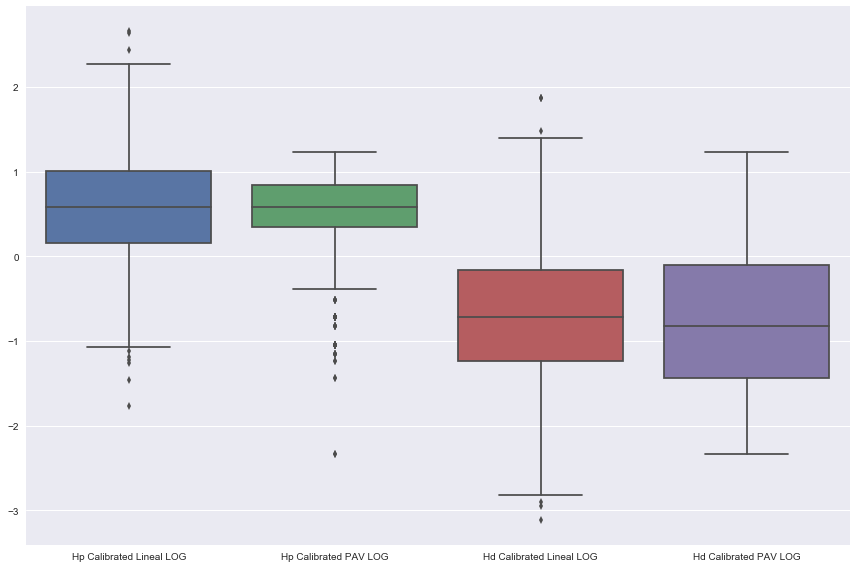

In [35]:
plt.figure(**global_style)

columns_name = "Hp Calibrated Lineal LOG", "Hp Calibrated PAV LOG", "Hd Calibrated Lineal LOG", "Hd Calibrated PAV LOG"
data = [Hp_calibrado_lineal_log, Hp_calibrado_PAV_log, Hd_calibrado_lineal_log, Hd_calibrado_PAV_log]

df = pd.DataFrame(np.array(data).T, columns=columns_name)

sns.boxplot(data=df)
plt.tight_layout()

#### Histogramas

Aunque inicialmente la calibración PAV parecía distorcional drásticamente los datos calibrados, al comprarla con la Platt, puede verse que el dominio de la distribución es muy similar y que se ve modificado por su forma de escalón. A grandes razgos podría decirse que la Calibración Platt produce Gaussianas simétricas y la PAV produce Gaussianas Asimétricas o Multimodales (dependiendo de los parámetros del KDE).

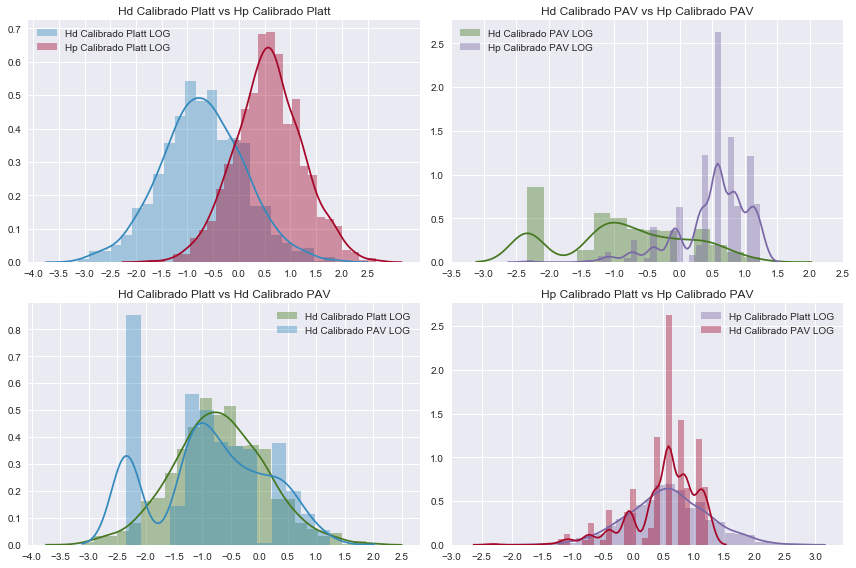

In [36]:
fig = plt.figure(**global_style)

ax1 = plt.subplot(222)
ax2 = plt.subplot(221)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

sns.distplot(Hd_calibrado_PAV_log, label="Hd Calibrado PAV LOG", ax=ax1, color=color_secondary_alt)
sns.distplot(Hp_calibrado_PAV_log, label="Hp Calibrado PAV LOG", ax=ax1, color=color_secondary)
ax1.set_xticks(np.arange(-3.5, 3, 0.5))
ax1.legend();
ax1.set_title('Hd Calibrado PAV vs Hp Calibrado PAV')

sns.distplot(Hd_calibrado_lineal_log, label="Hd Calibrado Platt LOG", ax=ax2, color=color_primary)
sns.distplot(Hp_calibrado_lineal_log, label="Hp Calibrado Platt LOG", ax=ax2, color=color_primary_alt)
ax2.set_xticks(np.arange(-4, 3, 0.5))
ax2.legend();
ax2.set_title('Hd Calibrado Platt vs Hp Calibrado Platt')

sns.distplot(Hd_calibrado_lineal_log, label="Hd Calibrado Platt LOG", ax=ax3, color=color_secondary_alt)
sns.distplot(Hd_calibrado_PAV_log, label="Hd Calibrado PAV LOG", ax=ax3, color=color_primary)
ax3.set_xticks(np.arange(-4, 3, 0.5))
ax3.legend()
ax3.set_title('Hd Calibrado Platt vs Hd Calibrado PAV')

sns.distplot(Hp_calibrado_lineal_log, label="Hp Calibrado Platt LOG", ax=ax4, color=color_secondary)
sns.distplot(Hp_calibrado_PAV_log, label="Hd Calibrado PAV LOG", ax=ax4, color=color_primary_alt)
ax4.set_xticks(np.arange(-3, 3.5, 0.5))
ax4.legend()
ax4.set_title('Hp Calibrado Platt vs Hp Calibrado PAV')

plt.tight_layout()

#### Curvas de Calibración

Debido a que la curva de calibración de la Platt es igual a la de los datos originales esta sección se omite.

#### Entrada / Salida

La función de la transformación es similar en la región central pero radicalmente diferente en los extremos, este comportamiento de escalon de la PAV es lo que le da su forma asimétrica y también lo que permite fijar límites superiores e inferiores para la salida. Si bien la calibración Platt produce resultados más similares a los originales, la PAV es más útil al momento de tomar decisiones sobre la fuerza de la evidencia y los umbrales de decisión.

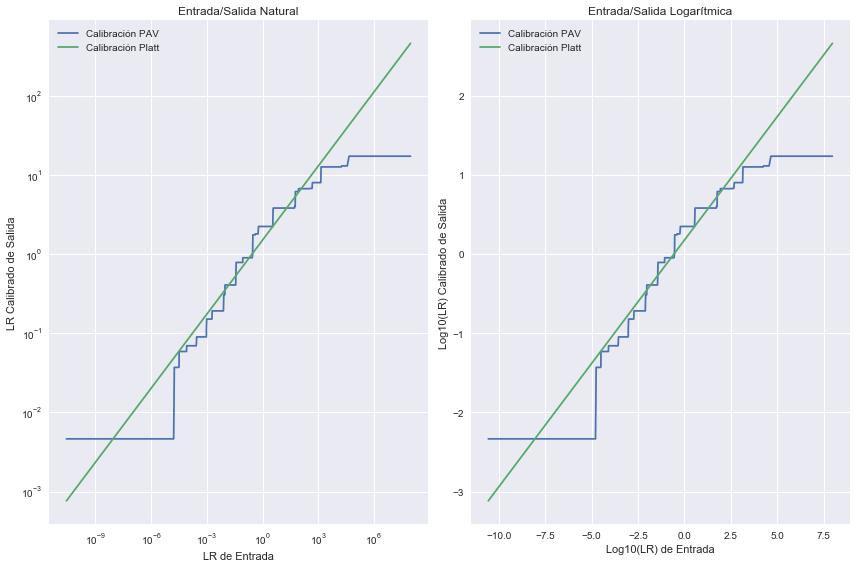

In [37]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(np.sort(np.concatenate([Hd_test, Hp_test])), np.sort(np.concatenate([Hd_calibrado_PAV, Hp_calibrado_PAV])), label="Calibración PAV")
ax1.plot(np.sort(np.concatenate([Hd_test, Hp_test])), np.sort(np.concatenate([Hd_calibrado_lineal, Hp_calibrado_lineal])), label="Calibración Platt")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('LR de Entrada')
ax1.set_ylabel('LR Calibrado de Salida')
ax1.set_title('Entrada/Salida Natural')
ax1.legend()

ax2.plot(np.sort(np.concatenate([Hd_test_log, Hp_test_log])), np.sort(np.concatenate([Hd_calibrado_PAV_log, Hp_calibrado_PAV_log])), label="Calibración PAV")
ax2.plot(np.sort(np.concatenate([Hd_test_log, Hp_test_log])), np.sort(np.concatenate([Hd_calibrado_lineal_log, Hp_calibrado_lineal_log])), label="Calibración Platt")
ax2.set_xlabel('Log10(LR) de Entrada')
ax2.set_ylabel('Log10(LR) Calibrado de Salida')
ax2.set_title('Entrada/Salida Logarítmica')
ax2.legend()

plt.tight_layout()

#### Curvas APE

En cuanto las curvas APE y el error de calibración, los valores son muy similares en ambos casos, siendo mejores los de la calibración PAV pero sólo por centécimas, por lo que se podrían considerar ambas técnicas muy buenas para la calibración

Discrimination Loss Calibración Platt: 0.5800257603642126
Calibration Loss Calibración Platt: 0.02016072892791143
Discrimination Loss Calibración PAV: 0.5800257603642126
Calibration Loss Calibración PAV: 0.019699545680709085


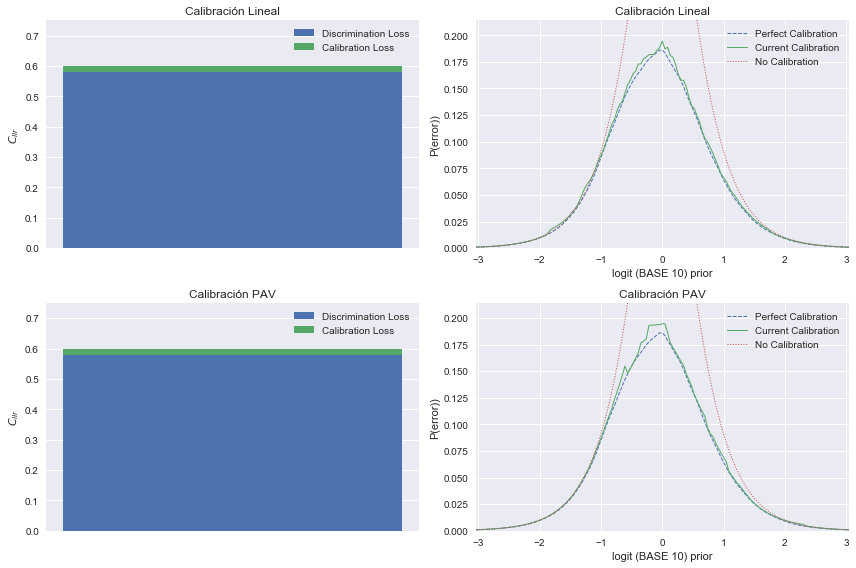

In [38]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plo = np.arange(-7, 7+0.1, 0.1)

clog, minclog, Pe, minPe, refPe = calc_ape(np.log(Hp_calibrado_lineal), np.log(Hd_calibrado_lineal), plo)
eer = 0
eer = max(eer,max(Pe))
y_lim = 0, eer * 1.1
x_lim = min(plo / np.log(10)) , max(plo / np.log(10))

ax1.bar(0, minclog, label="Discrimination Loss")
ax1.bar(0, clog - minclog, bottom=minclog, label="Calibration Loss")
ax1.set_ylim(0, .75)
ax1.set_ylabel('$C_{llr}$')
ax1.set_title("Calibración Lineal")
ax1.set_xticks([], [])
ax1.legend()
print(f"Discrimination Loss Calibración Platt: {minclog}")
print(f"Calibration Loss Calibración Platt: {clog - minclog}")

interval = 1 / np.log(10)
ax2.plot(interval * plo, minPe, label="Perfect Calibration", linestyle="dashed", linewidth=1)
ax2.plot(interval * plo, Pe, label="Current Calibration", linewidth=1)
ax2.plot(interval * plo, refPe, label="No Calibration", linestyle=":", linewidth=1)
ax2.set_ylabel('P(error))')
ax2.set_xlabel('logit (BASE 10) prior')
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_title("Calibración Lineal")
ax2.legend()

clog, minclog, Pe, minPe, refPe = calc_ape(np.log(Hp_calibrado_PAV), np.log(Hd_calibrado_PAV), plo)
eer = 0
eer = max(eer,max(Pe))
y_lim = 0, eer * 1.1

ax3.bar(0, minclog, label="Discrimination Loss")
ax3.bar(0, clog - minclog, bottom=minclog, label="Calibration Loss")
ax3.set_ylim(0, .75)
ax3.set_ylabel('$C_{llr}$')
ax3.set_title("Calibración PAV")
ax3.set_xticks([], [])
ax3.legend()
print(f"Discrimination Loss Calibración PAV: {minclog}")
print(f"Calibration Loss Calibración PAV: {clog - minclog}")

interval = 1 / np.log(10)
ax4.plot(interval * plo, minPe, label="Perfect Calibration", linestyle="dashed", linewidth=1)
ax4.plot(interval * plo, Pe, label="Current Calibration", linewidth=1)
ax4.plot(interval * plo, refPe, label="No Calibration", linestyle=":", linewidth=1)
ax4.set_xlim(x_lim)
ax4.set_ylim(y_lim)
ax4.set_title("Calibración PAV")
ax4.set_ylabel('P(error))')
ax4.set_xlabel('logit (BASE 10) prior')
ax4.legend()

plt.tight_layout()

Calibration Loss Calibración Platt: 0.02016072892791143
Calibration Loss Calibración PAV: 0.019699545680709085


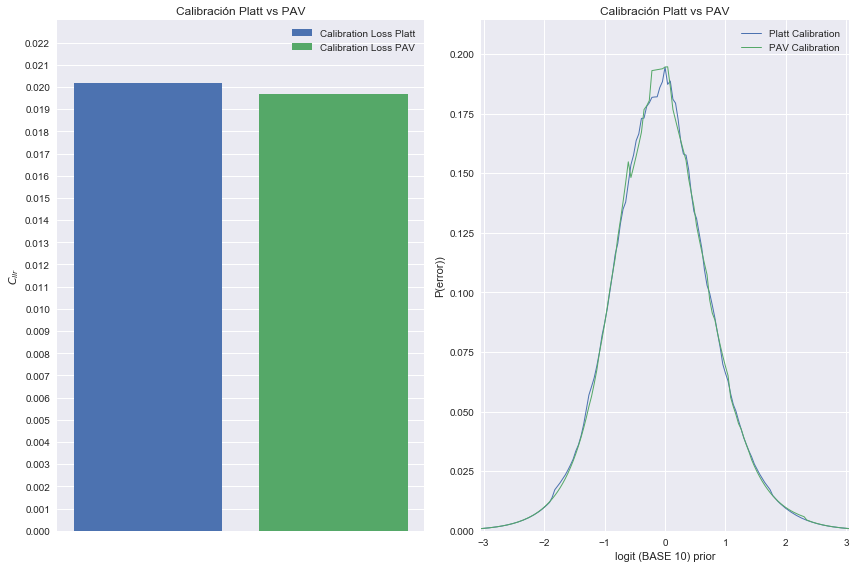

In [39]:
fig = plt.figure(**global_style)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plo = np.arange(-7, 7+0.1, 0.1)

clog1, minclog1, Pe1, *_ = calc_ape(np.log(Hp_calibrado_lineal), np.log(Hd_calibrado_lineal), plo)
clog2, minclog2, Pe2, *_ = calc_ape(np.log(Hp_calibrado_PAV), np.log(Hd_calibrado_PAV), plo)

eer = 0
eer = max(eer,max(Pe1), max(Pe2))
y_lim = 0, eer * 1.1
x_lim = min(plo / np.log(10)) , max(plo / np.log(10))

ax1.bar(0, clog1 - minclog1, label="Calibration Loss Platt")
ax1.bar(1, clog2 - minclog2, label="Calibration Loss PAV")
ax1.set_ylim(0, .023)
ax1.set_ylabel('$C_{llr}$')
ax1.set_title("Calibración Platt vs PAV")
ax1.set_xticks([], [])
ax1.set_yticks(np.arange(0, 0.023, 0.001))
ax1.legend()
print(f"Calibration Loss Calibración Platt: {clog1 - minclog1}")
print(f"Calibration Loss Calibración PAV: {clog2 - minclog2}")

interval = 1 / np.log(10)
ax2.plot(interval * plo, Pe1, label="Platt Calibration", linewidth=1)
ax2.plot(interval * plo, Pe2, label="PAV Calibration", linewidth=1)
ax2.set_ylabel('P(error))')
ax2.set_xlabel('logit (BASE 10) prior')
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_title("Calibración Platt vs PAV")
ax2.legend()

plt.tight_layout()

### Conclusiones Finales

A lo largo de este trabajo se desarrollaron los conceptos principales de la calibración extrínseca desde un ejercicio práctico, curvas de calibración, curvas APE, curvas ROC y DET y también análisis de Histogramas, Box Plots y Funciones de transformación.

La calibración es una técnica necesaria para que las salidas de los clasificadores sean lo más útiles posibles para la toma de decisiones. En este trabajo sea analizaron dos, la Platt y la PAV en el contexto de los clasificadores binarios (dos clases). Se pudo trabajar perfectamente unicamente con la salida (scores) de un clasificador sin saber como funciona el mismo y en ambos casos se logró reducir el error de calibración.

La técnica de Platt permite obtener valores calibrados con una distribución similar a la original mientras que la de PAV produce una función escalón con un límite máximo y mínimo. La calibración de ambas fue muy similar y deberían analizarse otros aspectos para determinar si alguna de las dos es superior a la otra. 

Algunos aspectos que se dejan como pendientes de estudio son:

- Costo computacional
- Interpretabilidad de los resultados (funcion de transformación)
- Complejidad algorítmica
- Rendimiento con pocos datos